# Quora question pairs: training

## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Initialize global variables

In [2]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'
MAX_SEQUENCE_LENGTH = 25
WORD_EMBEDDING_DIM = 300
SENT_EMBEDDING_DIM = 64
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25

## Load the dataset, embedding matrix and word count

In [3]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [4]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [5]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q2)

attention = dot([q1,q2], [1,1])
attention = Flatten()(attention)
attention = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention)
attention = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention)

merged = add([q1,attention])
merged = Flatten()(merged)
#merged = Dense(200, activation='relu')(merged)
#merged = BatchNormalization()(merged)
#merged = Dense(200, activation='relu')(merged)
#merged = BatchNormalization()(merged)
#merged = Dense(200, activation='relu')(merged)
#merged = BatchNormalization()(merged)
#merged = Dense(200, activation='relu')(merged)
#merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 25)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 25)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 25, 300)       28679100    input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 25, 300)       28679100    input_2[0][0]                    
___________________________________________________________________________________________

## Train the model, checkpointing weights with best validation accuracy

In [7]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=512,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-05-31 23:51:42.788919
Train on 327474 samples, validate on 36387 samples
Epoch 1/25
128s - loss: 0.5259 - acc: 0.7433 - val_loss: 0.4710 - val_acc: 0.7686
Epoch 2/25
127s - loss: 0.4437 - acc: 0.7861 - val_loss: 0.4495 - val_acc: 0.7834
Epoch 3/25
127s - loss: 0.4060 - acc: 0.8090 - val_loss: 0.4381 - val_acc: 0.7922
Epoch 4/25
128s - loss: 0.3727 - acc: 0.8278 - val_loss: 0.4329 - val_acc: 0.8006
Epoch 5/25
130s - loss: 0.3413 - acc: 0.8445 - val_loss: 0.4289 - val_acc: 0.8041
Epoch 6/25
129s - loss: 0.3119 - acc: 0.8601 - val_loss: 0.4456 - val_acc: 0.8022
Epoch 7/25
133s - loss: 0.2850 - acc: 0.8736 - val_loss: 0.4628 - val_acc: 0.8061
Epoch 8/25
130s - loss: 0.2594 - acc: 0.8867 - val_loss: 0.4796 - val_acc: 0.8060
Epoch 9/25
130s - loss: 0.2359 - acc: 0.8982 - val_loss: 0.5081 - val_acc: 0.8060
Epoch 10/25
131s - loss: 0.2133 - acc: 0.9088 - val_loss: 0.5266 - val_acc: 0.8038
Epoch 11/25
130s - loss: 0.1937 - acc: 0.9187 - val_loss: 0.5834 - val_acc: 0.80

## Plot training and validation accuracy

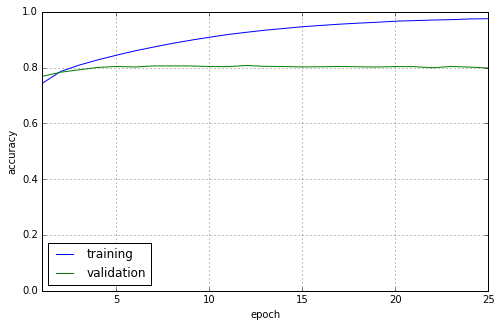

In [8]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

In [9]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 12 = 0.8075


## Evaluate the model with best validation accuracy on the test partition

In [10]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.6519, accuracy = 0.8067
